# Supernova distances and redshifts - part II

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.cosmology import LambdaCDM
from tqdm import tqdm

I take the same dataset as the previous exercise.

C:\Users\loren\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\loren\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


(35.0, 50.0)

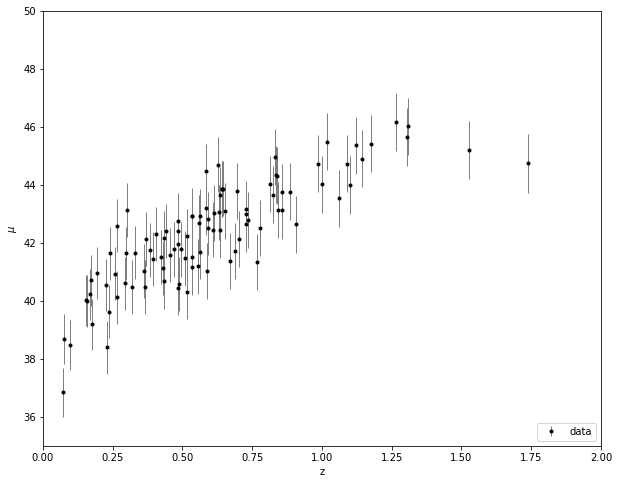

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

fig = plt.figure(figsize=(10, 8))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

In [3]:
z = np.linspace(0.01, 2, 1000)

Let's do some **cross validation** in order to find the best parameters in *Gaussian Process Regression*

In [4]:
from sklearn.model_selection import train_test_split

mu = np.array([mu_sample, dmu]).T

z_train, z_val, mudmu_train, mudmu_val = train_test_split(z_sample[:, np.newaxis], mu, test_size=0.3, random_state=42)
mu_train, dmu_train = mudmu_train.T
mu_val, dmu_val = mudmu_val.T

In [5]:
def geterror(X, y, classifier):
    
    return np.sqrt( np.sum(( y - classifier.predict(X) )**2) / len(X) )

def fitanderror(classifier):
    
    classifier.fit(z_train, mu_train)
    error_train = geterror(z_train, mu_train, classifier)
    error_validation  = geterror(z_val, mu_val, classifier)
    return error_train, error_validation

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

c_values = np.linspace(0.1, 10, 20)
k_values = np.linspace(0.1, 10, 20)

err_train, err_test = [], []

for c in c_values:
    for k in k_values:
        
        kernel = ConstantKernel(c, constant_value_bounds='fixed') * RBF(k, length_scale_bounds='fixed')
        classifier = GaussianProcessRegressor(kernel=kernel, random_state=42, normalize_y=True, optimizer=None)
        
        error_train, error_validation = fitanderror(classifier)
        err_train.append((c, k, error_train))
        err_test.append((c, k, error_validation))

# minimum validation error
best_idx = np.argmin([e[2] for e in err_test])
best_c, best_k, min_error = err_test[best_idx]

print(f'Best c: {best_c}, Best k: {best_k}, Min Validation Error: {min_error}')

Best c: 1.6631578947368424, Best k: 1.6631578947368424, Min Validation Error: 0.8052256819431334


I now fit through *GaussianProcessRegressor* using the best parameters of the kernel.

In [7]:
kernel = ConstantKernel(best_c) * RBF(best_k)
gp = GaussianProcessRegressor(kernel=kernel, alpha = dmu**2)
gp.fit(z_sample[:, np.newaxis], mu_sample)
y_pred, dy_pred = gp.predict(z[:, np.newaxis], return_std=True)

I plot the resulting fit with 1-$\sigma$ and 2-$\sigma$ contours.

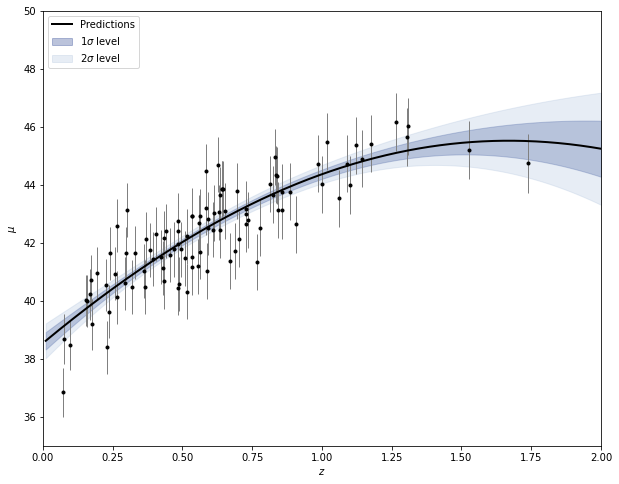

In [8]:
fig = plt.figure(figsize=(10, 8))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

plt.plot(z, y_pred, "-k", linewidth=2, label="Predictions")

plt.fill_between(z, y_pred - dy_pred, y_pred + dy_pred, color='#1E3A8A', alpha=0.3, label = '1$\\sigma$ level')
plt.fill_between(z, y_pred - 2 * dy_pred, y_pred + 2 * dy_pred, color='#B0C4DE', alpha=0.3, label = '2$\\sigma$ level')

plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.legend(loc="upper left")
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

The model seems to fit pretty well the data.

**Parameter estimation**

In [9]:
import emcee
import scipy.stats as scistats
import corner
import dynesty

I recall the relation between the distance module $\mu$ and the redshift $z$:

 $$ \mu = 5 \log \left( \frac{c/H_0}{10pc} (1+z) \int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3) + \Omega_{\Lambda}}} \right) \ , $$ 

where $c$ is the speed of light, $H_0$ is the Hubble constant, $\Omega_m$ and $\Omega_{\Lambda}$ are respectively the matter and the cosmological constant contents in the universe.

In [10]:
def generativemodel(z, H0, Om=1):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value

In [11]:
def LogLikelihood(theta):
    Om,H0 = theta    
    if Om<0:
        return -np.inf
    else:
        mu_model = generativemodel(z_sample, H0, Om)
    
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

def log_prior(theta):
    Om,H0 = theta
    if 0.1 < Om < 1 and 50.0 < H0 < 100.0:
        return 0.0
    
    return -np.inf

def log_posterior(theta):
    return LogLikelihood(theta) + log_prior(theta)

In [12]:
nsteps = int(1e4)
nwalkers, ndim = 5, 2
starting_guess = np.array([0.5, 80]) + 1e-1 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

for sample in tqdm(sampler.sample(starting_guess, iterations=nsteps), total=nsteps):
    pass  

100%|██████████| 10000/10000 [02:00<00:00, 82.78it/s]


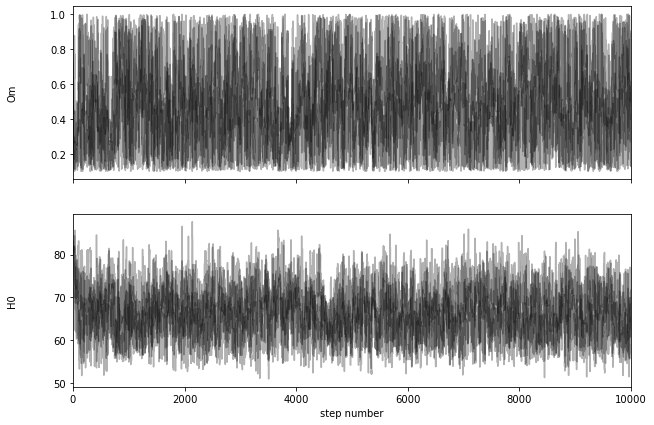

In [13]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels_param = ["Om", "H0"] 
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels_param[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [14]:
tau = sampler.get_autocorr_time()
print(tau)

[60.90898101 58.1071185 ]


In [15]:
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(815, 2)


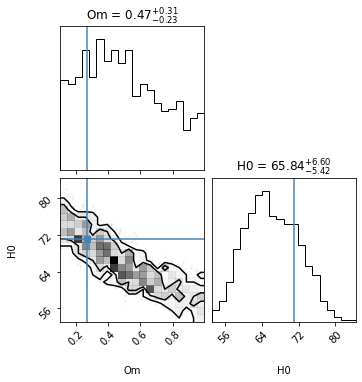

In [16]:
fig = corner.corner(
    flat_samples, labels=["Om","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71]
);

I notice a preferred direction in the plane of $H_0$ and $\Omega_m$!

In [17]:
zlin = np.linspace(0,2,100)[1:]

(35.0, 50.0)

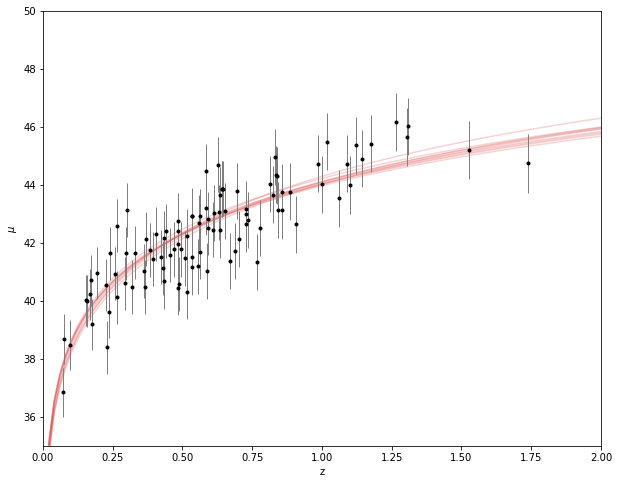

In [18]:
fig = plt.figure(figsize=(10, 8))

for Om,H0, in flat_samples[::100]:
    plt.plot(zlin, generativemodel(zlin, H0, Om),c='C3',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

I notice that the last two right points in the dataset are a bit dispersed in respect to the other ones, therefore i now check the importance of these by redoing the MCMC sampling by omitting them.

In [19]:
rm_idx = np.where(z_sample > 1.5)

z_sample_new = np.delete(z_sample, rm_idx)
mu_sample_new = np.delete(mu_sample, rm_idx)
dmu_new = np.delete(dmu, rm_idx)

In [20]:
def LogLikelihood_nolastpoints(theta):
    Om,H0 = theta    
    if Om<0:
        return -np.inf
    else:
        mu_model = generativemodel(z_sample_new, H0, Om)
    
    return np.sum(scistats.norm(loc=mu_model, scale=dmu_new).logpdf(mu_sample_new))

def log_posterior_nolastpoints(theta):
    return LogLikelihood_nolastpoints(theta) + log_prior(theta)

In [21]:
nsteps = int(1e4)
nwalkers, ndim = 5, 2
starting_guess = np.array([0.5, 80]) + 1e-1 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_nolastpoints)

for sample in tqdm(sampler.sample(starting_guess, iterations=nsteps), total=nsteps):
    pass  

100%|██████████| 10000/10000 [01:54<00:00, 87.19it/s]


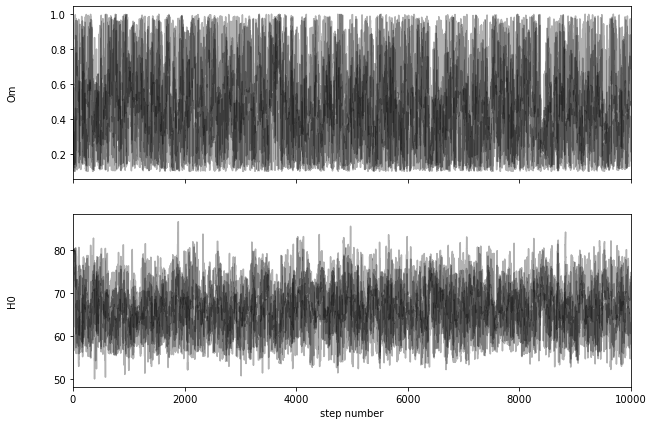

In [22]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels_param = ["Om", "H0"] 
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels_param[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [23]:
tau = sampler.get_autocorr_time()
print(tau)

[51.59827116 54.16650643]


In [24]:
flat_samples_nolastpoints = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(815, 2)


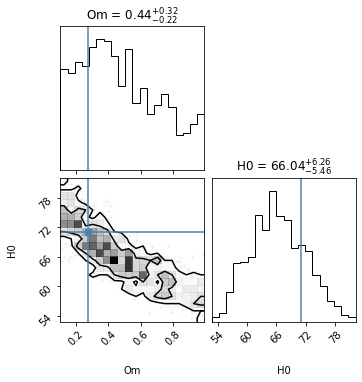

In [25]:
fig = corner.corner(
    flat_samples_nolastpoints, labels=["Om","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71]
);

(35.0, 50.0)

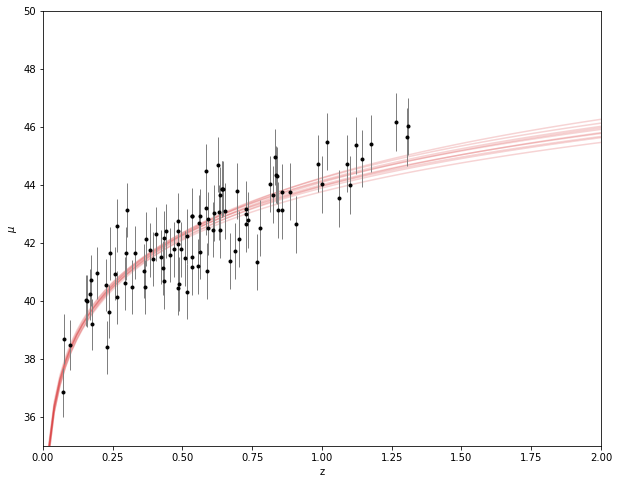

In [26]:
fig = plt.figure(figsize=(10, 8))

for Om,H0, in flat_samples_nolastpoints[::100]:
    plt.plot(zlin, generativemodel(zlin, H0, Om),c='C3',alpha=0.2)
    
plt.errorbar(z_sample_new, mu_sample_new, dmu_new, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

I can notice that, in respect to the previous fit, the result is pretty similar.

Since i noticed before a preferred direction in the $H_0$ / $\Omega_m$ plane, i try to apply **Principal Component Analysis**.

In [27]:
X = np.column_stack((z_sample, mu_sample))

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(2)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_fit = pca.fit_transform(X_scaled)

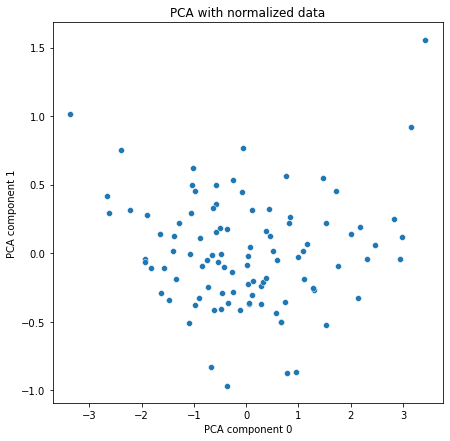

Variance on the first component: 0.9170805335297432
Variance on the second component: 0.08291946647025698


In [29]:
import seaborn as sns

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(x=X_fit[:,0], y=X_fit[:,1])
plt.xlabel("PCA component 0")
plt.ylabel("PCA component 1")

plt.title("PCA with normalized data")
plt.show()

print("Variance on the first component:", pca.explained_variance_ratio_[0])
print("Variance on the second component:", pca.explained_variance_ratio_[1])

This result tells me indeed that the bulk of the information is contained along the first principal component.

I can ask myself how a model without dark energy would perform.

In [30]:
def LogLikelihood_noDE(theta):
    H0 = float(theta)
    Om = 1
    mu_model = generativemodel(z_sample, H0, Om)
    
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

def log_prior_noDE(theta):
    H0 = float(theta)
    if 50.0 < H0 < 100.0:
        return 0.0
    return -np.inf

def log_posterior_noDE(theta):

    return LogLikelihood_noDE(theta) + log_prior_noDE(theta)

In [31]:
nsteps = int(1e4)
nwalkers, ndim = 5, 1
starting_guess = 80 + 1e-1 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_noDE)

for sample in tqdm(sampler.sample(starting_guess, iterations=nsteps), total=nsteps):
    pass  

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\loren\AppData\Local\Temp\ipykernel_25472\787729927.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H0 = float(theta)
C:\Users\loren\AppData\Local\Temp\ipykernel_25472\787729927.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H0 = float(theta)
100%|██████████| 10000/10000 [01:55<00:00, 86.66it/s]


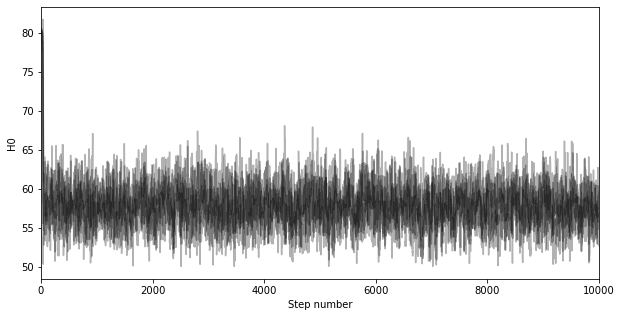

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
samples = sampler.get_chain()

ax.plot(samples[:, :, 0], "k", alpha=0.3)
ax.set_xlim(0, len(samples))
ax.set_ylabel("H0")
ax.set_xlabel("Step number")

plt.show()

In [33]:
tau = sampler.get_autocorr_time()
print(tau)

[33.48893775]


In [34]:
flat_samples_noDE = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples_noDE.shape)

(1500, 1)


In [35]:
flat_samples_H0_noDE = flat_samples_noDE.ravel()

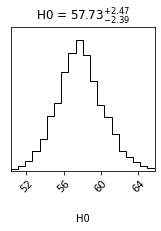

In [36]:
fig = corner.corner(
    flat_samples_H0_noDE, labels=["H0"], levels=[0.68,0.95], show_titles=True, truths=[71]
);

(35.0, 50.0)

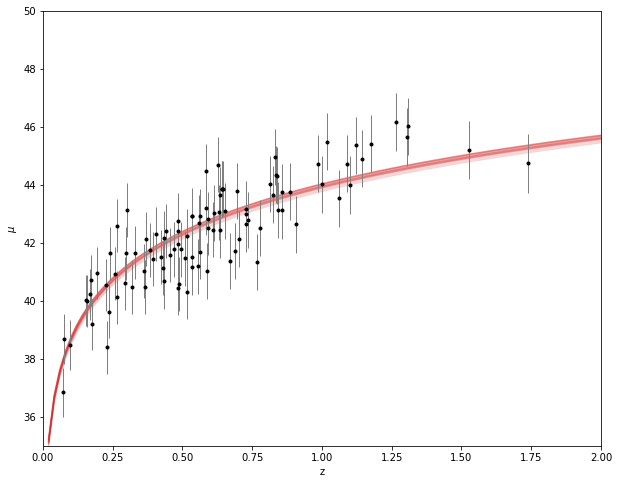

In [37]:
fig = plt.figure(figsize=(10, 8))

for H0 in flat_samples_H0_noDE[::100]:
    plt.plot(zlin, generativemodel(zlin, float(H0), 1),c='C3',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

Here i can notice that the fit is actually pretty good. But actually we don't know if we live in an universe with $H_0 \sim 60$ without dark energy or in an universe with $H_0 \sim 70$ but with dark energy. So, i can compute the Bayes factor through **Savage-Dickey**.

In [85]:
from scipy.stats import gaussian_kde

def kde_density(samples, value):
    kde = gaussian_kde(samples)
    return kde.evaluate(value)[0]

H0_fixed = 57 # fixed value of the noDE-model

# i estimate the posterior probability of the model whithout DE through a gaussian kde computation
posterior_dens_model2 = kde_density(flat_samples_H0_noDE, H0_fixed)

In [86]:
from scipy.stats import norm

def prior_density(H0, mean=70, std=10):
    return norm.pdf(H0, mean, std)

# i estimate the prior probability of the full model through a gaussian distribution, centered in H0
prior = prior_density(H0_fixed)

In [88]:
bayes_factor = posterior_dens_model2 / prior
print(f'Bayes factor: {bayes_factor}')

Bayes factor: 9.405798585170313


Since the Bayes Factor is largely bigger than 1, the preferred model is the one which includes the existance of dark energy.

**Upsampling**

I study the distribution of $z$.

In [41]:
from astroML import stats as astroMLstats
sigmaG2 = astroMLstats.sigmaG(z_sample)
print(sigmaG2)

0.2812393413227701


In [42]:
binsize = 2.7*sigmaG2/(len(z_sample)**(1/3))
print(binsize)
binsG = np.append(np.arange(start=z_sample.min(), stop=z_sample.max(), step=binsize), z_sample.max())
print(len(binsG))
print(binsG)

0.16359618414982324
12
[0.07346547 0.23706166 0.40065784 0.56425402 0.72785021 0.89144639
 1.05504258 1.21863876 1.38223494 1.54583113 1.70942731 1.7374507 ]


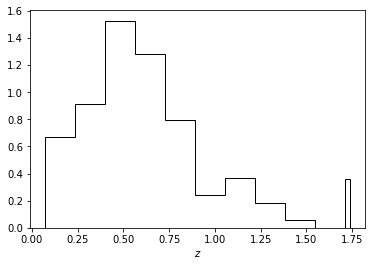

In [43]:
plt.hist(z_sample, bins=binsG, density=True, histtype='step', edgecolor='black')
plt.xlabel('$z$')
plt.show()

In [44]:
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [45]:
def kde_sklearn(data, bandwidth, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(np.linspace(z_sample.min(), z_sample.max(), 100)[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

In [46]:
bwrange = np.linspace(0.01,1.0, 10)
print(bwrange)
K = 5 # 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K)
grid.fit(z_sample[:, np.newaxis])
h_opt = grid.best_params_['bandwidth']
print(h_opt)

[0.01 0.12 0.23 0.34 0.45 0.56 0.67 0.78 0.89 1.  ]
0.12


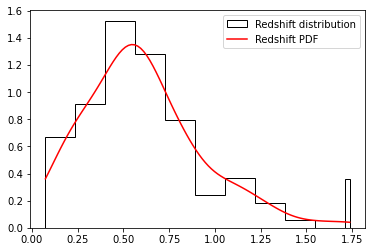

In [47]:
PDF_z = kde_sklearn(z_sample, bandwidth=h_opt, kernel="gaussian")
h_z = fancyhist(z_sample, bins=binsG, histtype="step", edgecolor='black', density=True, label='Redshift distribution')
plt.plot(np.linspace(z_sample.min(), z_sample.max(), 100), PDF_z, color='red', label='Redshift PDF')
plt.legend()
plt.show()

I upsample a bit the redshift distribution, through the *Inverse Transform* method.

In [48]:
PDF_z_normalized = PDF_z / np.sum(PDF_z)

cdf_z = np.cumsum(PDF_z_normalized)
cdf_z /= cdf_z[-1]

uniform_samples = np.random.rand(1000)

z_new = np.interp(uniform_samples, cdf_z, z_sample) # i take other redshift points following the original z distribution

In [49]:
flat_samples[np.random.choice(flat_samples.shape[0])]

array([ 0.71484313, 59.71058339])

In [50]:
mu_mcmc=[]
mu_gpr=[]
for z in z_new:
    Om,H0 = flat_samples[np.random.choice(flat_samples.shape[0])]
    mu_mcmc.append(generativemodel(z,H0,Om))
    
    
    mu_fit, sigma = gp.predict([[z]], return_std=True)
    mu_gpr.append(np.random.normal(loc=mu_fit,scale=sigma))

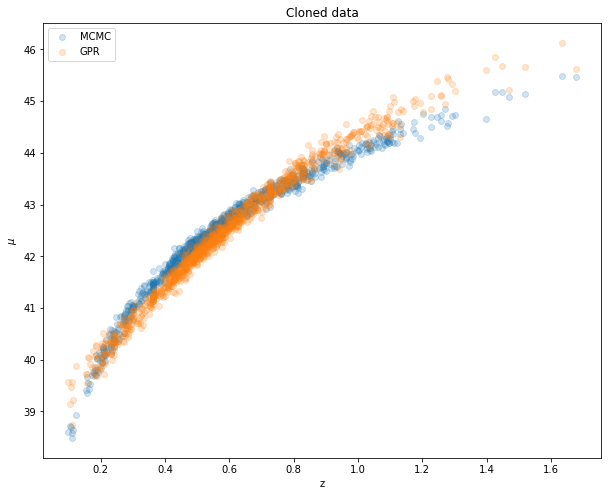

In [51]:
fig = plt.figure(figsize=(10, 8))

plt.scatter(z_new, mu_mcmc, alpha=0.2, label="MCMC")
plt.scatter(z_new, mu_gpr, alpha=0.2, label='GPR')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title("Cloned data")
plt.legend();